This notebook is constituted by 2 parts, P1: Momentum Strategy with data come from Yahoo Finance and Wikipedia
P2: Portfolio construct

# P1: MoM Strategy with Web Scraping 

In [1]:
import bs4
import numpy as py
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
import xlsxwriter
from itertools import repeat
import urllib.request as urllib2
from urllib.request import urlopen
from io import StringIO
import csv
import numpy as np
import lxml
import glob


In [6]:
url ='https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'#get the sourse website for the stock name of each stock in SP500
page = urllib2.urlopen(url)


In [7]:
request1=requests.get(url)
soup = BeautifulSoup(request1.text)

tb=soup.find_all('table',attrs = {'id':'constituents'})
for i in tb:
    j = i.find_all('tr')

In [8]:
jj = j[1:]
k = []
for i in jj:#find the company name of sp500
    k.append(i.find_all('td')[0].text.strip())
    
    
    
h = []
for i in k:
    if '.' not in i:
        h.append(i)
    else:
        h.append(i.replace('.','-'))#change all name in the same format

In [2]:
os.chdir("/Users/a32294/raw data")

In [11]:

for i in h:#download the 503 stocks data from Yahoo Finance from 01.01.2019 - 30.12.2019
    try:
        urlcsv = f'https://query1.finance.yahoo.com/v7/finance/download/{i}?period1=1546300800&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'
        data=urlopen(urlcsv).read().decode('ascii','ignore')
        dataf=StringIO(data)
        csvReader=pd.read_csv(dataf)
        csvReader.to_csv(f'sp_{i}.csv', mode='a',encoding='utf-8',header=0,index=False)
    except:
        pass
        print(i)
        


        #four stocks cannot be found because they are not went public at that time
        #CARR went public on 2.19.2022
        #CEG went public on 2.2.2022
        #OGN  went public on 3.6.2021
        #OTIS went public on 3.19.2020


    #for row in csvReader:
     # print(row)

    #for table in pd.read_html(urlcsv):
        #table.to_csv(f'/Users/smile/Desktop/WS/sp_{i}.csv', mode='a',encoding='utf-8',header=0,index=False)

CARR
CEG
OGN
OTIS


In [3]:
### open the indicate contect
path = '/Users/a32294/raw data'
c = glob.glob(path + '/*.csv')
jj = []
for i in c:
    jj.append(i.split('data/')[1])###save the name of csv data

In [4]:
jjl = []
for i in jj:   ### combiane data to the three column dataframe with the value of Date ,close price,Ticker
    v = pd.read_csv(i,header = None)
    v['Ticker'] = i.split('_')[1].split('.')[0]
    v = v[[0,4,'Ticker']]
    v.columns = ['Date','Close price','Ticker']
    v.index = v.Date
    v = v.drop('Date',axis=1)
    jjl.append(v)
    

In [5]:
bb = pd.concat(jjl)

In [6]:
b2 = bb.copy()


In [7]:
m = []
m.append(b2.index.unique())### find all the time period

In [8]:
hj = []
for i in m:### dont know reason , data been copied three times, so drop all duplicated value 
    hj.append(b2.loc[i].drop_duplicates())

In [9]:
kk = pd.concat(hj,axis=0)

In [10]:
ti = kk.Ticker.unique()

In [11]:
b3 = b2.copy()
b3['Date'] = b3.index
b3.index = b3.Ticker
b3 = b3.drop('Ticker',axis=1) ## make data look better


In [12]:
kl = []
for i in ti:
    tar = b3.loc[i].drop_duplicates()
    tar.index = tar.Date
    c = tar['Close price']
    c = pd.DataFrame(tar['Close price'])
    c.columns = [i]
    kl.append(c)

In [13]:
target = pd.concat(kl,axis=1) ## now

In [14]:
rr = target / target.shift(1) - 1 ### rate of return
r = 1+rr ###return+1

In [15]:
### for long

def f(x,y):### x represents the ticker position,y is the strategy beginning date
    try:
        qi = rr[ti[x]].iloc[y-3:y]# qi is the target return period, I take three consecutive dates as strategy implimentation period
        if (qi.isna()).any():
            pass
        elif (qi.dropna() < 0).any():
            return('na')
        else:
            return(ti[x])
    except:
        pass
        

In [16]:
### for short

def y(x,y):
    try:
        qi = rr[ti[x]].iloc[y-3:y]
        if (qi.isna()).any():
            pass
        elif (qi.dropna() > 0).any():
            return('na')
        else:
            return(ti[x])
    except:
        pass
        

In [17]:
kk = []
for q in range(4,252):
    vk = []
    for i in range(len(ti)):
        w = f(i,q)
        if w not in ['na',None]:
            vk.append(w)
        else:
            pass
    kk.append(vk)#### the target names at the specified date under Long strategy


In [18]:
kki = []
for q in range(4,252):
    vk = []
    for i in range(len(ti)):
        g = y(i,q)
        if g not in ['na',None]:
            vk.append(g)
        else:
            pass
    kki.append(vk)#### the target names at the specified date under Short strategy

In [19]:
jk = pd.DataFrame(kk).T

jk.columns = m[0][4:]

In [20]:
ret = []###
for i in range(len(jk.columns)-1):
    ty = kk[i]
    oi = np.average(rr.loc[jk.columns[i+1]][ty]) ####oi is the return of Long strategy with EQUAL WEIGHTS
    ret.append([oi])

In [21]:
rett = []
for i in range(len(jk.columns)-1):
    ty = kki[i]
    if len(ty) > 0:
        oi = np.average(rr.loc[jk.columns[i+1]][ty]) ####oi is the return of Short strategy with EQUAL WEIGHTS
        rett.append([oi * (-1)])
    else:
        oi = 'No short position taday'
        rett.append([oi])


In [22]:
long = pd.DataFrame(ret,jk.columns[0:-1])
long.columns = ['Return']
long.sum()

Return    0.162564
dtype: float64

In [23]:
long

,Return
Date,
2019-01-08,0.000850
2019-01-09,0.007568
2019-01-10,0.000807
2019-01-11,-0.006137
2019-01-14,0.007813
...,...
2019-12-23,0.000281
2019-12-24,0.004278
2019-12-26,-0.001708


In [24]:
short = pd.DataFrame(rett,index = jk.columns[0:-1])
short.columns = ['Return']
short

,Return
Date,
2019-01-08,-0.00880537
2019-01-09,-0.0041087
2019-01-10,0.00169249
2019-01-11,0.00542439
2019-01-14,-0.0130865
...,...
2019-12-23,-0.00237693
2019-12-24,-0.00438864
2019-12-26,0.000704373


In [25]:
SR1 = (long.sum() - 0.01) / long.std()


In [26]:
TR = rr.sum(axis = 0)

In [27]:
import matplotlib.pyplot as plt

In [28]:
TR2 = rr.sum(axis=1) /  499 ###average of equal weights of  all stock

In [29]:
TR2T = pd.DataFrame(TR2[long.index])
TR2T.columns = ['Total Universe']

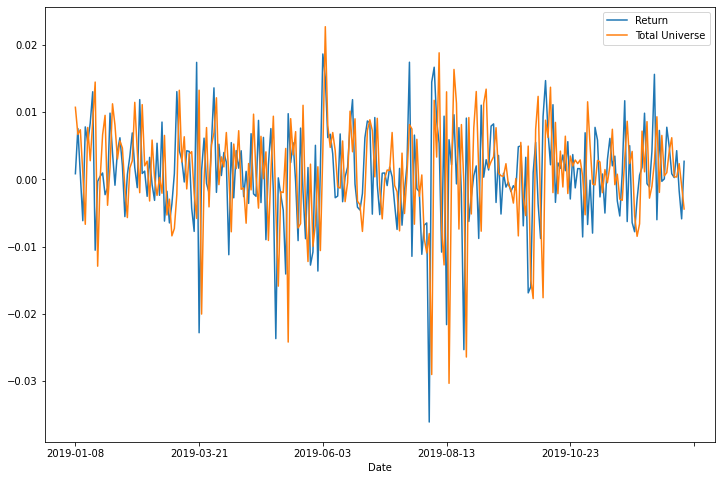

In [30]:
res = pd.concat([long,TR2T],axis=1).plot(figsize = (12,8));

In [31]:
T1 = long.sum()[0]
S1 = long.std()[0]
T2 = TR2T.sum()[0]
S2 = TR2T.std()[0]

In [32]:
re = pd.DataFrame([[T1,S1],[T2,S2]],index = ['MoM','Equally Weighted'])
re.columns = ['Return','STD']
re

,Return,STD
MoM,0.162564,0.007413
Equally Weighted,0.258717,0.007603


# P2: Portfolio Construction with AR Model 

In [33]:
import statsmodels

In [34]:
from statsmodels.tsa.ar_model import AutoReg

In [35]:
import matplotlib.pyplot as plt

In [36]:
import pandas
from pandas.core.frame import DataFrame

In [37]:
x=[9,8,7,6,5,4,3,2,1] # assume long memory from last period to last 9 periods
newrr= rr.iloc[1:200,:] # train dataset
result=[]

for i in rr.columns:
    try:
        a = AutoReg(newrr[i],lags = x).fit()
        t=pd.DataFrame([a.params,a.pvalues])
        result.append(t)
    except:
        pass

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will chan

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will chan

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will chan

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will chan

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will chan

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will chan

In [38]:
"""Keep the AR memory period that significant at 5% significance level"""
hj = []
for i in range(len(result)):
    tar = np.where(result[i].loc[1] < 0.05)[0].tolist()
    li = result[i].loc[1].index[tar].tolist()
    try:
        va = result[i][li].iloc[0]
    except:
        pass
    hj.append(va)

In [39]:
'''drop all const params as const parameter is not relevant, only focus on significant periods'''
jh = []
for i in hj:
    if 'intercept' in i.index: 
        a = i.drop('intercept')
        jh.append(a)
    else:
        jh.append(i)

In [40]:
def f(x):
    w = []
    for q in x.index.tolist():
        w.append(q.split('.L')[1])
    return(w)

In [41]:
li = []
for i in jh:
    if len(i) == 0:
        li.append('None')
    else:
        va = f(i)
        li.append(va)

In [42]:
va = []
for i in jh:
    if len(i) == 0:
        va.append('None')
    else:
        va.append(i.values.tolist())

In [43]:
res = pd.DataFrame([li,va])
res.columns = newrr.dropna(axis=1).columns
res = res.T

In [44]:
res.columns = ['Lags','Params']
rr_copy=rr.copy()

In [45]:
llll=res.index[np.where(res['Lags'] == 'None')[0]]

In [46]:
newrr=newrr.drop(columns = llll,axis=1)

In [47]:
newres=res.drop(index = llll.tolist())
newres

,Lags,Params
FLT,"[2, 5]","[-0.14207750052378718, -0.22328576243611375]"
CMCSA,[1],[-0.16809997567760576]
NVR,[4],[-0.17479400972137682]
DVN,[5],[0.14259541350931634]
TPR,[2],[-0.15279198466028304]
...,...,...
INCY,[5],[-0.15788413604433144]
SCHW,[2],[0.20834090137622432]
SO,"[2, 3, 4]","[-0.2221960739888686, -0.14932899825437224, -0..."
BMY,[3],[-0.14440370490302412]


In [48]:
newrr = newrr.dropna(axis=1)

In [49]:
def y(x):
    y = []
    if len(x) == 1:
        y.append(float(x[0]))
    else:
        for i in x:
            y.append(float(i))
    return(y)

In [50]:
def f(x,z):
    o = []
    lags = np.subtract(y(newres['Lags'][x]),1).tolist()
    params = newres['Params'][x]
    t = pd.DataFrame([lags,params])
    for i in range(t.shape[1]):
        re = newrr[x][int(z - t[i][0])] 
        if re > 0:
            o.append(1)
        else:
            o.append(-1)
    return(o)

In [51]:
def f2(x):
    j = []
    for i in newrr.columns:
        j.append(f(i,x))
    return(j)

In [52]:
gh = []
for i in range(9,newrr.shape[0]):
    gh.append(f2(i))

In [53]:
result = pd.DataFrame(gh)
result.columns = newrr.columns

In [54]:
result.index = newrr.index[range(9,newrr.shape[0])]

In [55]:
result

,FLT,CMCSA,NVR,DVN,TPR,TWTR,PEAK,SPGI,GD,LNT,...,CDW,JNJ,CRM,BWA,HD,INCY,SCHW,SO,BMY,AEP
2019-01-16,"[1, 1]",[1],[1],[1],[-1],[1],[1],"[1, 1]",[1],"[1, -1, -1]",...,[-1],[1],[-1],[-1],[1],[1],[1],"[1, -1, 1]",[-1],"[1, -1, -1]"
2019-01-17,"[1, -1]",[1],[-1],[1],[-1],[-1],[1],"[1, 1]",[1],"[1, -1, 1]",...,[-1],[-1],[1],[1],[1],[-1],[1],"[1, 1, -1]",[1],"[1, -1, 1]"
2019-01-18,"[1, -1]",[1],[1],[-1],[1],[1],[1],"[1, 1]",[1],"[1, 1, -1]",...,[1],[1],[-1],[1],[-1],[-1],[1],"[1, 1, 1]",[-1],"[1, 1, -1]"
2019-01-22,"[1, 1]",[-1],[-1],[1],[1],[1],[1],"[1, 1]",[-1],"[1, 1, -1]",...,[1],[-1],[1],[1],[1],[1],[1],"[1, 1, 1]",[1],"[1, 1, -1]"
2019-01-23,"[-1, 1]",[1],[-1],[-1],[-1],[-1],[1],"[-1, 1]",[1],"[1, 1, 1]",...,[1],[1],[1],[1],[-1],[-1],[-1],"[-1, 1, 1]",[1],"[1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-10,"[1, 1]",[1],[-1],[-1],[1],[-1],[-1],"[1, -1]",[1],"[1, -1, 1]",...,[1],[-1],[-1],[-1],[-1],[-1],[1],"[1, -1, -1]",[-1],"[1, 1, 1]"
2019-10-11,"[1, -1]",[1],[1],[-1],[1],[1],[1],"[1, 1]",[1],"[-1, -1, 1]",...,[-1],[-1],[1],[-1],[1],[-1],[1],"[-1, 1, -1]",[1],"[-1, -1, 1]"
2019-10-14,"[1, -1]",[-1],[-1],[-1],[1],[1],[-1],"[1, 1]",[-1],"[-1, 1, -1]",...,[-1],[-1],[-1],[1],[1],[-1],[1],"[-1, -1, 1]",[-1],"[-1, 1, 1]"
2019-10-15,"[-1, 1]",[1],[-1],[1],[-1],[-1],[1],"[-1, 1]",[1],"[-1, -1, -1]",...,[1],[-1],[1],[1],[-1],[1],[1],"[-1, -1, -1]",[1],"[-1, -1, -1]"


In [56]:
def f3(x):
    if len(x) == 1:
        y = x[0]
    else:
        if np.sum(x)!= len(x):
            y = 0
        else:
            y = x[0]
    return(y)

In [57]:
ret = []
for q in range(result.shape[0]):
    ty = []
    for i in result.columns:
        ind = result.index[q]
        try:
            ind2 = result.index[q + 1]
            a = f3(result[i][ind]) * newrr[i][ind2]
            ty.append(a)
        except:
            pass
    ret.append(ty)
    
ret2 = []  
for i in range(len(ret)):
    ret2.append(pd.Series(ret[i]).mean())
    

<ipython-input-57-5f91b3ba6898>:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ret2.append(pd.Series(ret[i]).mean())


In [58]:
yt = []
for i in ret2:
    yt.append(i + 1)

In [59]:
r1 = pd.Series(yt).mean() - 1
s1 = pd.Series(yt).std()
SR1 = (r1 / s1 )  

In [60]:
newrr2 = rr.iloc[200:,:][result.columns]
newrr2 

,FLT,CMCSA,NVR,DVN,TPR,TWTR,PEAK,SPGI,GD,LNT,...,CDW,JNJ,CRM,BWA,HD,INCY,SCHW,SO,BMY,AEP
2019-10-17,-0.003222,0.007237,0.019852,-0.013075,-0.002353,-0.007517,0.004343,0.002774,-0.008582,0.008606,...,0.002426,0.007398,-0.005443,-0.008088,0.003688,-0.008833,0.011020,-0.000491,0.017666,0.004320
2019-10-18,-0.006976,-0.007838,0.030026,-0.028459,0.004717,-0.015653,0.010541,-0.009960,-0.013182,0.004551,...,-0.000484,-0.062202,-0.014230,0.018937,0.004899,0.004262,0.012421,0.001310,0.011637,0.012258
2019-10-21,0.001268,0.011192,-0.018724,0.022222,0.026604,0.028212,0.004814,0.003753,0.005848,0.003209,...,0.001211,0.002506,0.003192,0.006195,-0.005170,0.010674,0.024036,0.007360,0.003206,0.003612
2019-10-22,-0.020260,-0.006727,-0.010733,0.021245,0.006479,-0.031928,-0.001331,-0.020842,0.025249,0.004139,...,-0.013300,0.009217,-0.015358,0.019497,0.002112,-0.001018,0.000489,-0.002435,0.022932,-0.003493
2019-10-23,0.017989,-0.001092,-0.001043,0.030479,-0.017418,0.000515,0.010928,-0.009221,-0.035135,0.005059,...,0.005147,0.005418,0.019673,0.006039,-0.010666,-0.005222,0.010997,0.008301,0.006431,0.003080
2019-10-24,0.016505,-0.019248,-0.004119,0.007512,-0.009249,-0.208087,-0.008964,0.018408,0.006395,0.000373,...,0.011460,-0.018476,0.020602,-0.017009,-0.003324,-0.007682,-0.009185,0.000000,-0.007303,0.013554
2019-10-25,0.008912,0.018064,-0.008448,0.000466,0.028783,-0.014634,-0.034318,0.003502,-0.006469,-0.008945,...,0.003295,0.006667,0.016001,0.010687,0.002095,0.000645,-0.000244,-0.009685,0.011219,-0.014313
2019-10-28,0.010606,-0.004600,-0.022561,-0.019562,-0.012098,-0.007921,-0.004132,-0.002728,0.008010,-0.008462,...,0.009050,0.006467,0.028573,0.017372,0.010325,0.029787,0.012201,-0.005542,0.011095,-0.010387
2019-10-29,-0.011455,-0.001981,-0.003332,0.016627,-0.009950,-0.006986,0.006916,0.030693,0.006288,-0.003983,...,0.001508,-0.000464,0.001938,-0.017817,-0.011233,0.043701,-0.012536,-0.001475,0.003238,-0.002142
2019-10-30,0.004823,-0.014553,-0.002594,-0.053738,0.014689,0.000335,0.013461,-0.006128,0.012555,0.008187,...,0.009510,0.028810,0.020569,-0.011590,0.008969,0.003719,0.008301,0.028070,0.019724,0.009982


In [61]:
gh2 = []
for i in range(9,newrr2.shape[0]):
    gh2.append(f2(i))

In [62]:
result2 = pd.DataFrame(gh2)
result2.columns = newrr2.columns
result2.index = newrr2.index[range(9,newrr2.shape[0])]

In [63]:
result2

,FLT,CMCSA,NVR,DVN,TPR,TWTR,PEAK,SPGI,GD,LNT,...,CDW,JNJ,CRM,BWA,HD,INCY,SCHW,SO,BMY,AEP
2019-10-30,"[1, 1]",[1],[1],[1],[-1],[1],[1],"[1, 1]",[1],"[1, -1, -1]",...,[-1],[1],[-1],[-1],[1],[1],[1],"[1, -1, 1]",[-1],"[1, -1, -1]"
2019-10-31,"[1, -1]",[1],[-1],[1],[-1],[-1],[1],"[1, 1]",[1],"[1, -1, 1]",...,[-1],[-1],[1],[1],[1],[-1],[1],"[1, 1, -1]",[1],"[1, -1, 1]"
2019-11-01,"[1, -1]",[1],[1],[-1],[1],[1],[1],"[1, 1]",[1],"[1, 1, -1]",...,[1],[1],[-1],[1],[-1],[-1],[1],"[1, 1, 1]",[-1],"[1, 1, -1]"
2019-11-04,"[1, 1]",[-1],[-1],[1],[1],[1],[1],"[1, 1]",[-1],"[1, 1, -1]",...,[1],[-1],[1],[1],[1],[1],[1],"[1, 1, 1]",[1],"[1, 1, -1]"
2019-11-05,"[-1, 1]",[1],[-1],[-1],[-1],[-1],[1],"[-1, 1]",[1],"[1, 1, 1]",...,[1],[1],[1],[1],[-1],[-1],[-1],"[-1, 1, 1]",[1],"[1, 1, 1]"
2019-11-06,"[1, 1]",[-1],[-1],[1],[1],[-1],[-1],"[1, -1]",[1],"[1, 1, 1]",...,[1],[1],[-1],[1],[-1],[1],[-1],"[1, -1, 1]",[-1],"[1, 1, 1]"
2019-11-07,"[-1, 1]",[-1],[-1],[1],[-1],[1],[-1],"[1, 1]",[1],"[1, 1, 1]",...,[-1],[-1],[1],[-1],[1],[-1],[1],"[1, 1, -1]",[1],"[1, 1, 1]"
2019-11-08,"[1, -1]",[-1],[1],[-1],[1],[1],[1],"[1, 1]",[-1],"[-1, 1, 1]",...,[1],[-1],[-1],[-1],[-1],[-1],[1],"[-1, 1, 1]",[-1],"[-1, 1, 1]"
2019-11-11,"[-1, 1]",[1],[1],[-1],[1],[1],[1],"[-1, 1]",[1],"[-1, 1, 1]",...,[-1],[-1],[1],[1],[1],[-1],[-1],"[-1, -1, 1]",[-1],"[1, 1, 1]"
2019-11-12,"[-1, -1]",[-1],[-1],[1],[-1],[-1],[1],"[-1, -1]",[1],"[1, -1, 1]",...,[1],[1],[-1],[1],[-1],[1],[1],"[1, -1, -1]",[-1],"[1, -1, 1]"


In [64]:
ret = []
for q in range(result2.shape[0]):
    ty = []
    for i in result2.columns:
        ind = result2.index[q]
        try:
            ind2 = result2.index[q + 1]
            a = np.sum(f3(result2[i][ind])) * newrr2[i][ind2]
            ty.append(a)
        except:
            pass
    ret.append(ty)
    
yt = []
for i in ret:
    yt.append(np.average(i))

ret3 = []
for i in yt:
    ret3.append(i + 1)

/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/a32294/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [65]:
r2 = (pd.Series(ret3).mean()) - 1
s2 = pd.Series(ret3).std()
SR2 = (r2  / s2 ) 
SR2

0.10833122716428646

In [71]:
rt = (rr.mean(axis=1) + 1).mean() - 1
st = np.std(rr.mean(axis=1) + 1)
SRT = rt / st

In [74]:
final = pd.DataFrame([[r1,r2,rt],[s1,s2,st],[SR1,SR2,SRT]])
final.index = ['Ann-Return','Ann-Std','Ann-SR']
final.columns = ['In-sample','Out-Of-Sample','Equal-Weights']

In [75]:
final 

,In-sample,Out-Of-Sample,Equal-Weights
Ann-Return,-0.000288,0.000146,0.001140
Ann-Std,0.001614,0.001350,0.007940
Ann-SR,-0.178206,0.108331,0.143563
